In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../')
sys.path.append('../')
import seaborn as sns 
from multiprocessing import Process
from omegaconf import OmegaConf
from core.run_lib import *
import numpy as np 
from core.passive_learning import *
from core.auto_labeling import *
from datasets import dataset_factory 
from datasets.dataset_utils import * 
from utils.common_utils import * 
from utils.vis_utils import *
from core.run_lib import * 
import copy 
import random 
from datasets.numpy_dataset import * 


root_dir = '../../../'
conf_dir = f'{root_dir}configs/calib-exp/'

base_conf_file = '{}/cifar10_small_net_base_conf.yaml'.format(conf_dir)
conf           = OmegaConf.load(base_conf_file)

training_conf  = OmegaConf.load('{}/training_confs/mmce_conf.yaml'.format(conf_dir))

root_pfx       = 'mnist_lenet_calib-exp-runs'
root_pfx       = f'{root_dir}/outputs/{root_pfx}/'


conf['root_pfx']    = root_pfx

conf.training_conf = training_conf


logger   = get_logger('../../../temp/logs/act_lbl_test.log',stdout_redirect=True,level=logging.DEBUG)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
conf['train_pts_query_conf']['seed_train_size']= 10 
conf['train_pts_query_conf']['max_num_train_pts']= 50

set_seed(conf['random_seed'])

dm = DataManager(conf,logger,lib=conf['model_conf']['lib'])

print(len(dm.ds_std_train), len(dm.ds_std_val))

pl = PassiveLearning(conf,dm,logger)

out = pl.run()

w = pl.cur_clf.get_weights()
print(torch.norm(w))
test_err = get_test_error(pl.cur_clf,dm.ds_std_test,conf['inference_conf'])
print(test_err)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../../data/cifar-10-python.tar.gz to ../../../data/
Files already downloaded and verified
50000
50000
[09/12/2023 07:58:51 PM : DEBUG : data_manag : ] : torch.Size([40000, 3, 32, 32])
[09/12/2023 07:58:51 PM : INFO  : data_manag : ] : Loaded dataset cifar10
[09/12/2023 07:58:51 PM : INFO  : data_manag : ] : Std train size: 40000 and Std. Val. Size:10000
40000 10000
[09/12/2023 07:58:51 PM : DEBUG : passive_le : ] : Querying 10 seed training points
[09/12/2023 07:58:51 PM : DEBUG : passive_le : ] : Queried 10 seed points for training
[09/12/2023 07:58:51 PM : DEBUG : passive_le : ] : Validation Data Size :5000
[09/12/2023 07:58:51 PM : DEBUG : passive_le : ] : Querying rest of the training points 40 in single batch
[09/12/2023 07:58:51 PM : INFO  : passive_le : ] : Labeled data size for training: 50
[09/12/2023 07:58:51 PM : INFO  : pytorch_cl : ] : {'model_name': 'cifar_small_net', 'num_classes': 10, 'lib': 'pytorch'}
[09/12/2023 07:58:51 PM : INFO  : passive_le : ] : ---

AssertionError: Torch not compiled with CUDA enabled

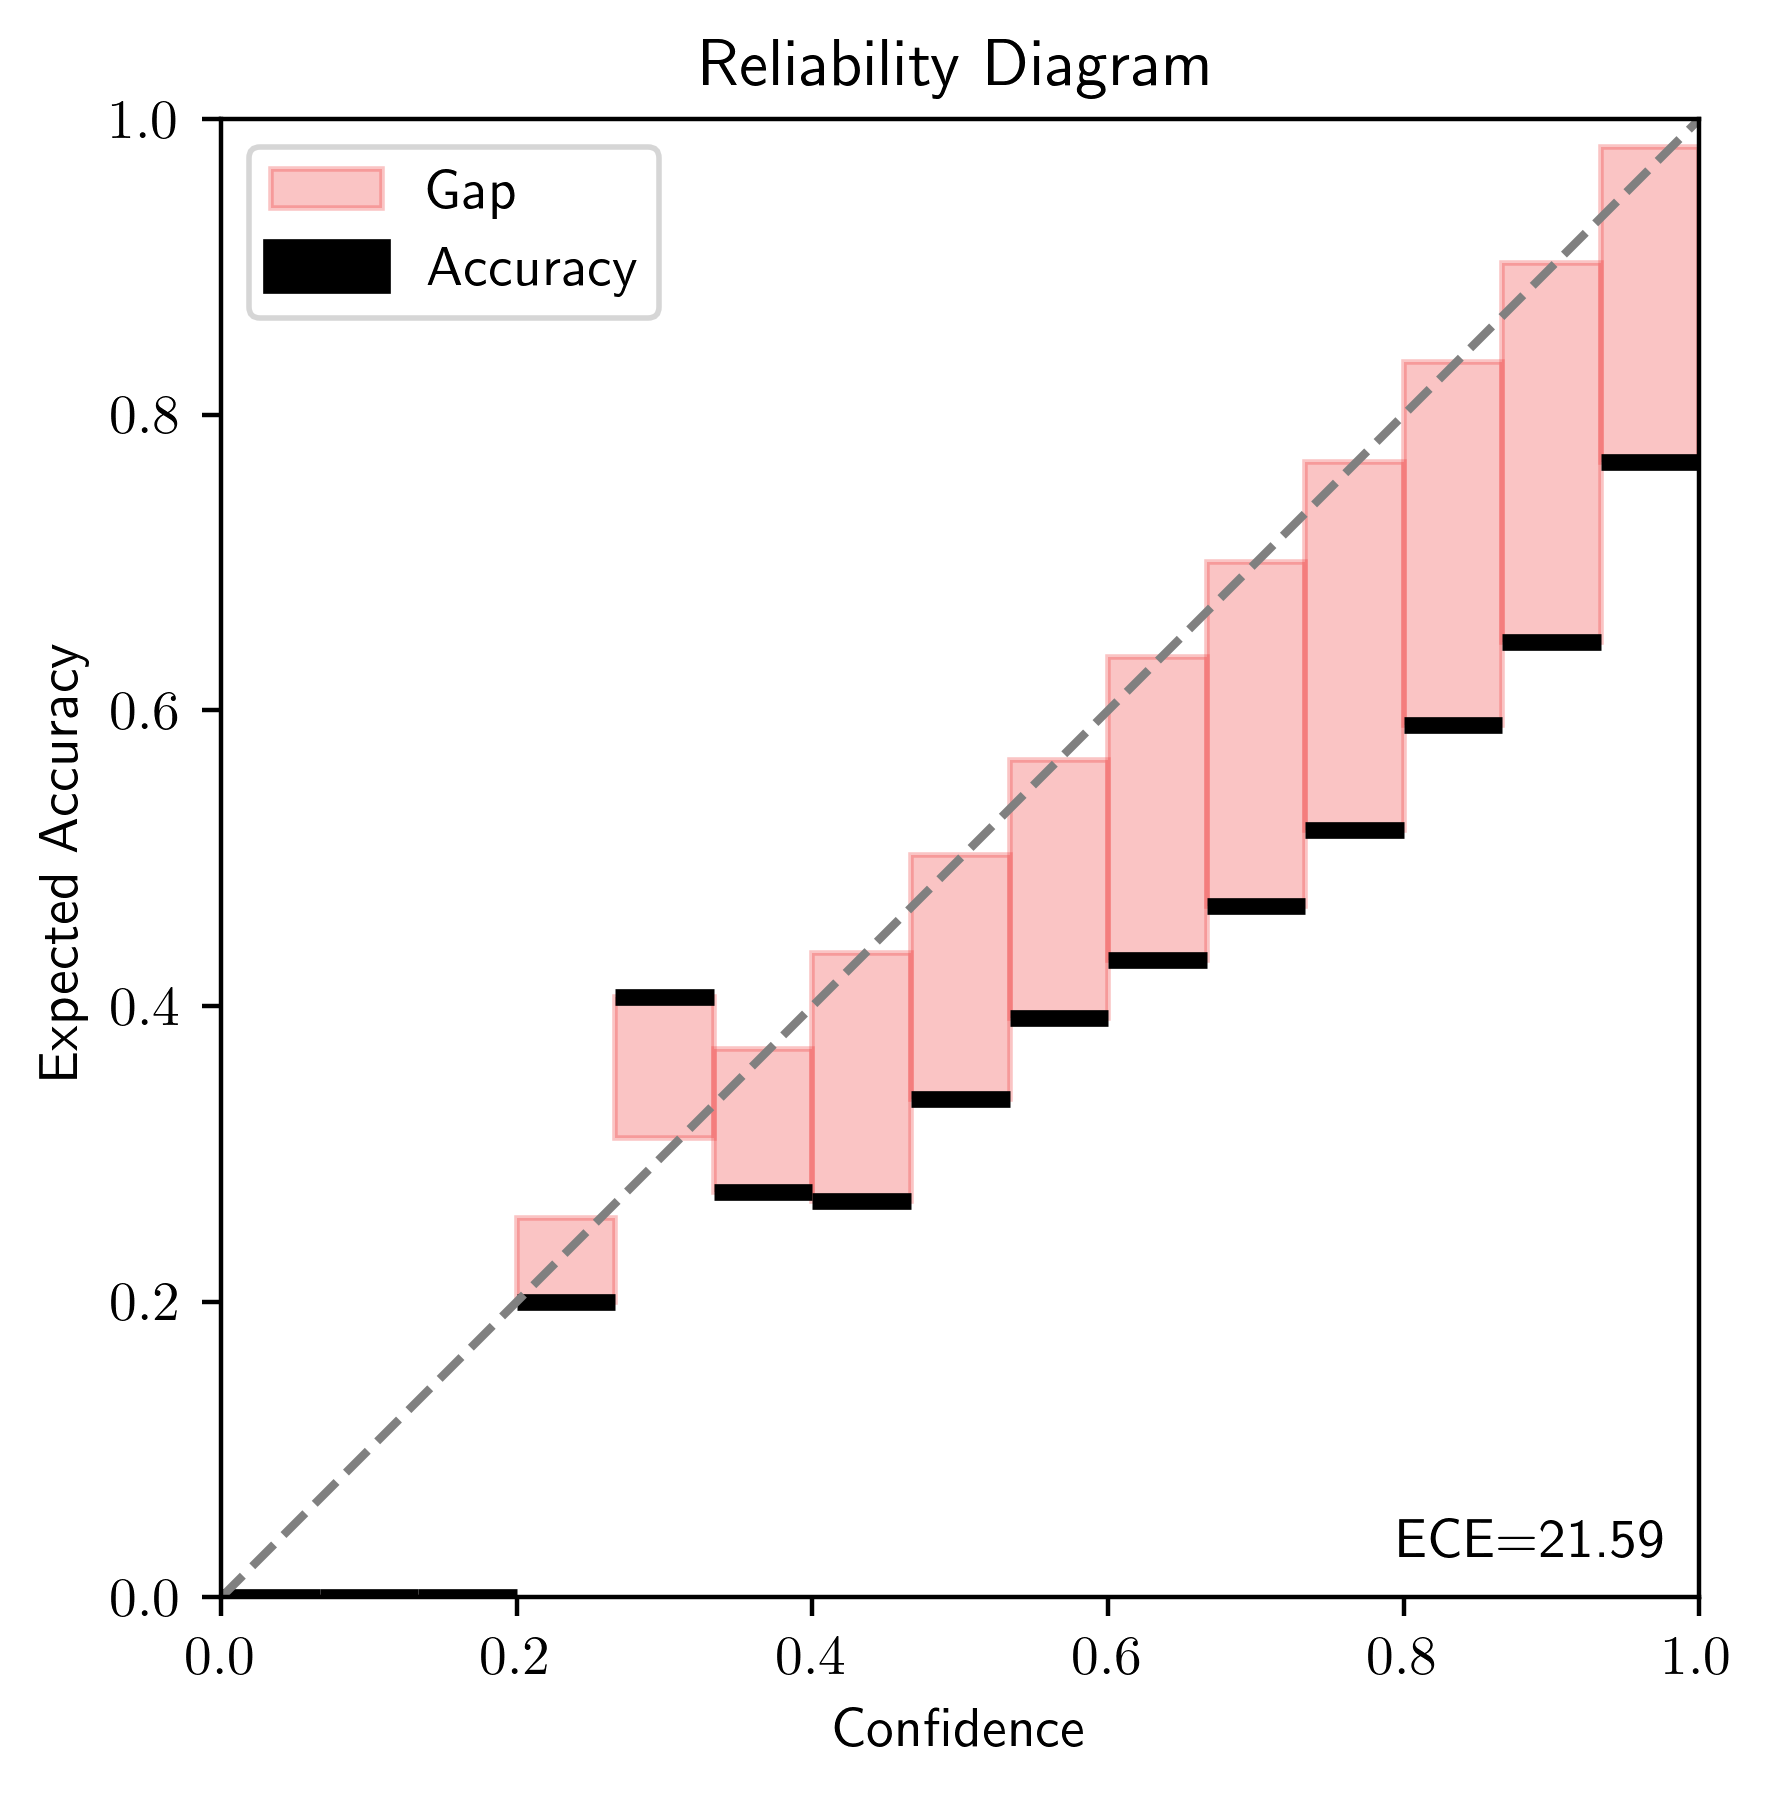

In [ ]:
inf_out = pl.cur_clf.predict(dm.ds_std_test,conf['inference_conf'])
bin_data = compute_calibration(dm.ds_std_test.Y, inf_out['labels'], inf_out['confidence'], num_bins=15)
ax = plt.subplot()
reliability_diagram_subplot(ax, bin_data, draw_ece=True, draw_bin_importance=False, title="Reliability Diagram",  xlabel="Confidence", ylabel="Expected Accuracy",disable_labels=False)

<Axes: ylabel='Density'>

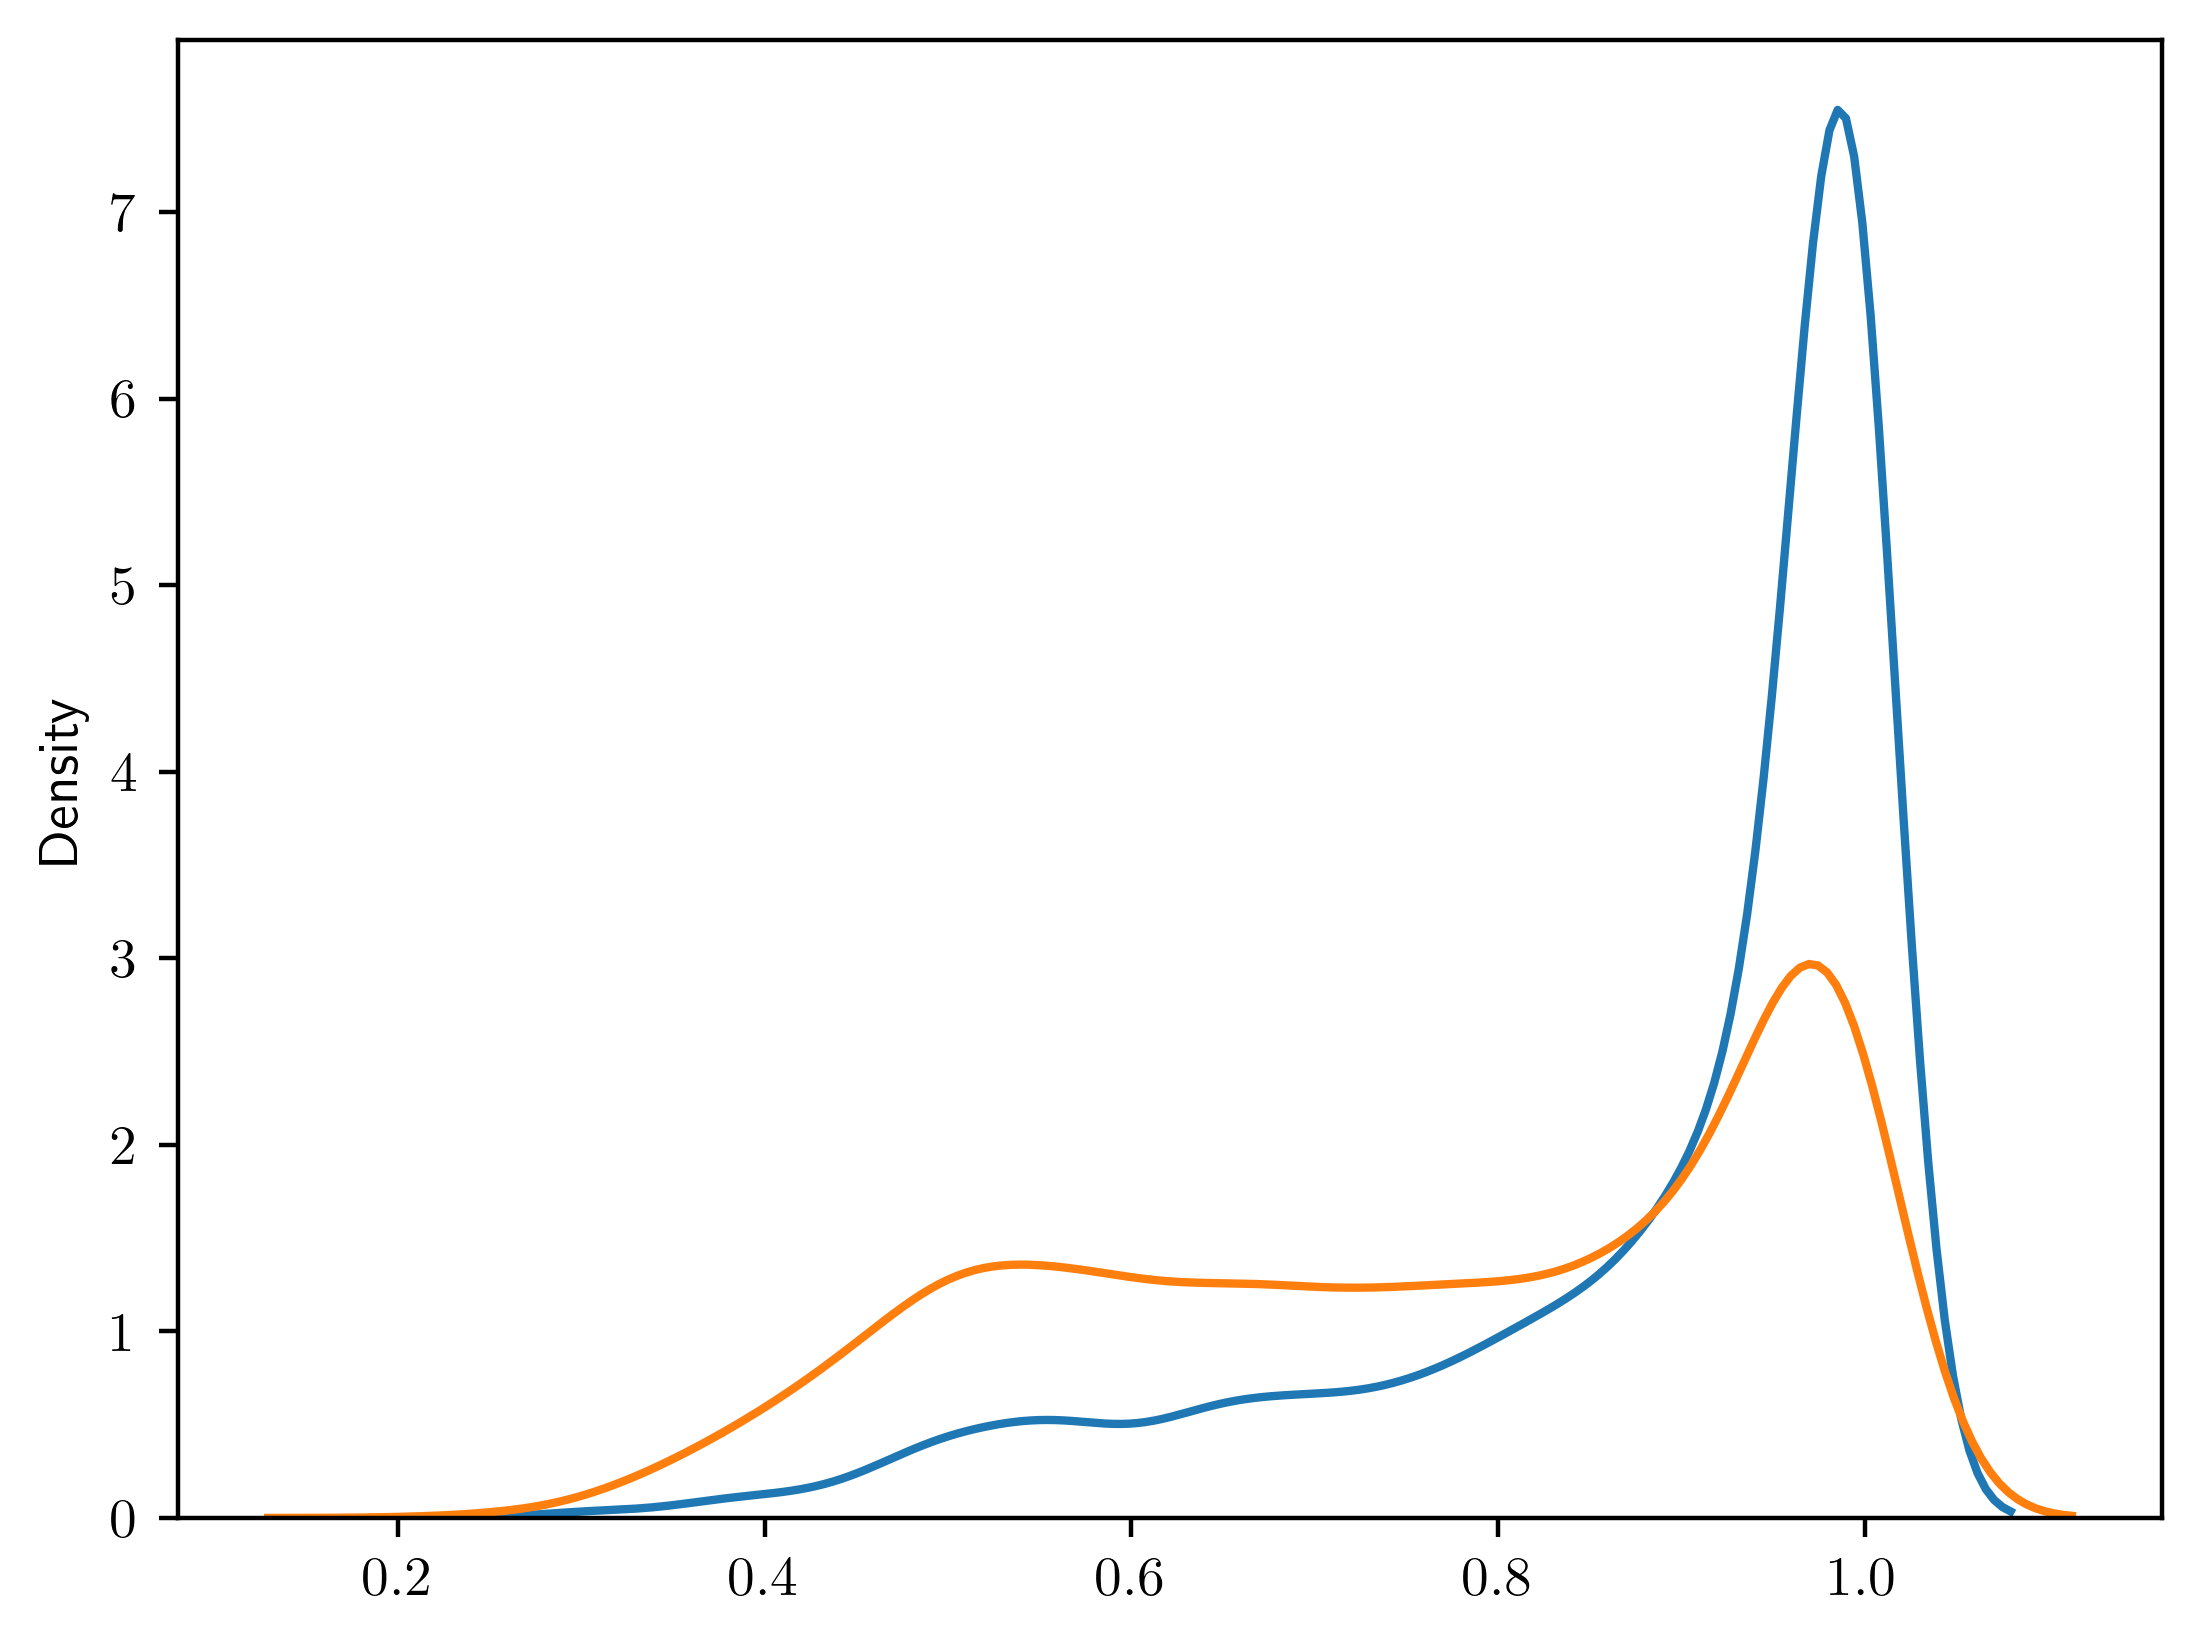

In [ ]:
lenet_clf_model = pl.cur_clf.model
test_ds = dm.ds_std_test

inference_conf = {} 
inference_conf['device']= 'cpu'
inf_out_test_1 = pl.cur_clf.predict(test_ds, inference_conf) 

inf_out_test_1['true_labels'] = test_ds.Y
c_idx = inf_out_test_1['true_labels'] ==  inf_out_test_1['labels']
i_idx =inf_out_test_1['true_labels'] !=  inf_out_test_1['labels']


sns.kdeplot(inf_out_test_1['confidence'][c_idx])
sns.kdeplot(inf_out_test_1['confidence'][i_idx])

#plt.hist(inf_out_val_1['confidence'][c_idx])
#plt.hist(inf_out_val_1['confidence'][i_idx])



In [ ]:
dm.unmark_auto_labeled()

auto_labeler = AutoLabeling(conf,dm,pl.cur_clf,logger)
out = auto_labeler.run()
out = dm.get_auto_labeling_counts()
print(out)

[09/12/2023 07:57:57 PM : INFO  : auto_label : ] : ========================= Begin Auto-Labeling selective ==========================
[09/12/2023 07:57:57 PM : DEBUG : auto_label : ] : Auto Labeling Conf : {'method_name': 'selective', 'score_type': 'confidence', 'class_wise': 'independent', 'auto_label_err_threshold': 0.05, 'C_1': 0, 'ucb': 'sigma', 'fast': True}
[09/12/2023 07:57:57 PM : INFO  : auto_label : ] : Number of unlabeled points : 41950
[09/12/2023 07:57:57 PM : INFO  : auto_label : ] : Using number of validation points : 5000
[09/12/2023 07:57:57 PM : INFO  : auto_label : ] : Using Auto-Labeling Error Threshold = 0.05
[09/12/2023 07:57:58 PM : DEBUG : auto_label : ] : Expected Calibration Error on Validation set : 0.22473217777609825
[09/12/2023 07:57:59 PM : INFO  : auto_label : ] : Determining Thresholds : Class Wise : independent
[09/12/2023 07:57:59 PM : DEBUG : threshold_ : ] : C_1 = 0 UCB = sigma
[09/12/2023 07:57:59 PM : INFO  : threshold_ : ] : auto-labeling thresho